In this example, random feedback local online (RFLO) learning is used to train a recurrent neural network (RNN) to produce a one-dimensional periodic output. Another RNN is trained using backpropagation through time (BPTT), and the performance of the two methods is compared. Real time recurrent learning (RTRL) can also be used, but it's much slower than the other methods.

The code may be reused and adapted, in which case please cite the following paper:

James M. Murray, "Local online learning in recurrent networks with random feedback," eLife (2018).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def theta(x):
    return 0.5*(1 + sign(x))


def f(x):
    return np.tanh(x)


def df(x):
    return 1/np.cosh(10*np.tanh(x/10))**2  # the tanh prevents oveflow


class RNN:
    '''
    A recurrent neural network. Given weights, the time-dependent
    input, and the initial state, return the time-dependent output.

    Parameters:
    ----------
    n_in, n_rec, n_out : number of input, recurrent, and hidden units.

    x : The input to the network. x[t,i] is input from unit i at timestep t.

    h0 : The initial state vector of the RNN.

    tau_m : The network time constant, in units of timesteps.

    noise_amp : Amplitude of Gaussian white noise to inject into the network
    '''

    def __init__(self, n_in, n_rec, n_out, h0, tau_m=10):
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out
        self.h0 = h0
        self.tau_m = tau_m

        # Initialize weights:
        self.w_in = 0.1*(np.random.rand(n_rec, n_in) - 1)
        self.w_rec = 1.5*np.random.randn(n_rec, n_rec)/n_rec**0.5
        self.w_out = 0.1*(2*np.random.rand(n_out, n_rec) - 1)/n_rec**0.5

        # Random error feedback matrix:
        self.b = np.random.randn(n_rec, n_out)/n_out**0.5


    def run_trial(self, x, y_, eta=[0.1, 0.1, 0.1],
                  learning=None, online_learning=False):
        '''
        Run the RNN for a single trial.

        Parameters:
        -----------
        x : The input to the network. x[t,i] is input from unit i at timestep t.

        y_ : The target RNN output, where y_[t,i] is output i at timestep t.

        eta : A list of 3 learning rates, for w_in, w_rec, and w_out,
            respectively.

        learning : Specify the learning algorithm with one of the following
            strings: 'rtrl', 'bptt', or 'rflo'. If None, run the network without
            learning.

        online_learning : If True (and learning is on), update weights at each
            timestep. If False (and learning is on), update weights only at the
            end of each trial. Online learning cannot be used with BPTT.

        Returns:
        --------
        y : The time-dependent network output. y[t,i] is output i at timestep t.

        h : The time-dependent RNN state vector. h[t,i] is unit i at timestep t.

        u : The inputs to RNN units (feedforward plus recurrent) at each
            timestep.
        '''

        # Boolean shorthands to specify learning algorithm:
        rtrl = learning is 'rtrl'
        bptt = learning is 'bptt'
        rflo = learning is 'rflo'

        [eta3, eta2, eta1] = eta  # learning rates for w_in, w_rec, and w_out
        t_max = np.shape(x)[0]  # number of timesteps

        dw_in, dw_rec, dw_out = 0, 0, 0  # changes to weights

        u = np.zeros((t_max, self.n_rec))  # input (feedforward plus recurrent)
        h = np.zeros((t_max, self.n_rec))  # time-dependent RNN activity vector
        h[0] = self.h0  # initial state
        y = np.zeros((t_max, self.n_out))  # RNN output
        err = np.zeros((t_max, self.n_out))  # readout error

        # If rflo, eligibility traces p and q should have rank 2; if rtrl, rank 3:
        if rtrl:
            p = np.zeros((self.n_rec, self.n_rec, self.n_rec))
            q = np.zeros((self.n_rec, self.n_rec, self.n_in))
        elif rflo:
            p = np.zeros((self.n_rec, self.n_rec))
            q = np.zeros((self.n_rec, self.n_in))
            
        for jj in range(self.n_rec):
            if rtrl:
                q[jj, jj, :] = df(u[0, jj])*x[0,:]/self.tau_m
            elif rflo:
                q[jj, :] = df(u[0, jj])*x[0,:]/self.tau_m

        for tt in range(t_max-1):
            u[tt+1] = np.dot(self.w_rec, h[tt]) + np.dot(self.w_in, x[tt+1])
            h[tt+1] = h[tt] + (-h[tt] + f(u[tt+1]))/self.tau_m
            y[tt+1] = np.dot(self.w_out, h[tt+1])
            err[tt+1] = y_[tt+1] - y[tt+1]  # readout error

            if rflo:
                p = (1-1/self.tau_m)*p
                q = (1-1/self.tau_m)*q
                p += np.outer(df(u[tt+1,:]), h[tt,:])/self.tau_m
                q += np.outer(df(u[tt+1,:]), x[tt,:])/self.tau_m
            elif rtrl:
                p = np.tensordot((1-1/self.tau_m)*np.eye(self.n_rec)
                    + df(u[tt+1])*self.w_rec/self.tau_m, p, axes=1)
                q = np.tensordot((1-1/self.tau_m)*np.eye(self.n_rec)
                    + df(u[tt+1])*self.w_rec/self.tau_m, q, axes=1)
                for jj in range(self.n_rec):
                    p[jj, jj, :] += df(u[tt+1, jj])*h[tt]/self.tau_m
                    q[jj, jj, :] += df(u[tt+1, jj])*x[tt+1]/self.tau_m

            if rflo and online_learning:
                dw_out = eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec = eta2*np.outer(np.dot(self.b, err[tt+1]),
                                       np.ones(self.n_rec))*p/t_max
                dw_in = eta3*np.outer(np.dot(self.b, err[tt+1]),
                                      np.ones(self.n_in))*q/t_max
            elif rflo and not online_learning:
                dw_out += eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec += eta2*np.outer(np.dot(self.b, err[tt+1]),
                                        np.ones(self.n_rec))*p/t_max
                dw_in += eta3*np.outer(np.dot(self.b, err[tt+1]),
                                       np.ones(self.n_in))*q/t_max
            elif rtrl and online_learning:
                dw_out = eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec = eta2/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), p, axes=1)
                dw_in = eta3/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), q, axes=1)
            elif rtrl and not online_learning:
                dw_out += eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec += eta2/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), p, axes=1)
                dw_in += eta3/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), q, axes=1)

            if online_learning and not bptt:
                self.w_out = self.w_out + dw_out
                self.w_rec = self.w_rec + dw_rec
                self.w_in = self.w_in + dw_in
            
        if bptt:  # backward pass for BPTT
            z = np.zeros((t_max, self.n_rec))
            z[-1] = np.dot((self.w_out).T, err[-1])
            for tt in range(t_max-1, 0, -1):
                z[tt-1] = z[tt]*(1 - 1/self.tau_m)
                z[tt-1] += np.dot((self.w_out).T, err[tt])
                z[tt-1] += np.dot(z[tt]*df(u[tt]), self.w_rec)/self.tau_m

                # Updates for the weights:
                dw_out += eta1*np.outer(err[tt], h[tt])/t_max
                dw_rec += eta2/(t_max*self.tau_m)*np.outer(z[tt]*df(u[tt]),
                                                            h[tt-1])
                dw_in += eta3/(t_max*self.tau_m)*np.outer(z[tt]*df(u[tt]),
                                                           x[tt])

        if not online_learning:  # wait until end of trial to update weights
            self.w_out = self.w_out + dw_out
            self.w_rec = self.w_rec + dw_rec
            self.w_in = self.w_in + dw_in

        return y, h, u


    def run_session(self, n_trials, x, y_, eta=[0.1, 0.1, 0.1],
                    learning=None, online_learning=False):
        '''
        Run the RNN for a session consisting of many trials.

        Parameters:
        -----------
        n_trials : Number of trials to run the RNN

        x : The time-dependent input to the RNN (same for each trial).

        y_ : The target RNN output (same for each trial).

        eta : A list of 3 learning rates, for w_in, w_rec, and w_out,
            respectively.

        learning : Specify the learning algorithm with one of the following
            strings: 'rtrl', 'bptt', or 'rflo'. If None, run the network without
            learning.

        online_learning : If True (and learning is on), update weights at each
            timestep. If False (and learning is on), update weights only at the
            end of each trial. Online learning cannot be used with BPTT.


        Returns:
        --------
        loss_list : A list with the value of the loss function for each trial.

        readout_alignment : The normalized dot product between the vectorized
            error feedback matrix and the readout matrix, as in Lillicrap et al
            (2016).
        '''

        t_max = np.shape(x)[0]  # number of timesteps
        loss_list = []
        readout_alignment = []

        # Flatten the random feedback matrix to check for feedback alignment:
        bT_flat = np.reshape((self.b).T,
            (np.shape(self.b)[0]*np.shape(self.b)[1]))
        bT_flat = bT_flat/np.linalg.norm(bT_flat)

        for ii in range(n_trials):
            y, h, u = self.run_trial(x, y_, eta, learning=learning,
                                     online_learning=online_learning)

            err = y_ - y
            loss = 0.5*np.mean(err**2)
            loss_list.append(loss)

            w_out_flat = np.reshape(self.w_out,
                (np.shape(self.w_out)[0]*np.shape(self.w_out)[1]))
            w_out_flat = w_out_flat/np.linalg.norm(w_out_flat)
            readout_alignment.append(np.dot(bT_flat, w_out_flat))
            print('\r'+str(ii+1)+'/'+str(n_trials)+'\t Err:'+str(loss), end='')

        return y, loss_list, readout_alignment



Training with BPTT...
10000/10000	 Err:0.0002316051313315921
Training with RFLO...
10000/10000	 Err:0.00015187803197067533

<IPython.core.display.Javascript object>


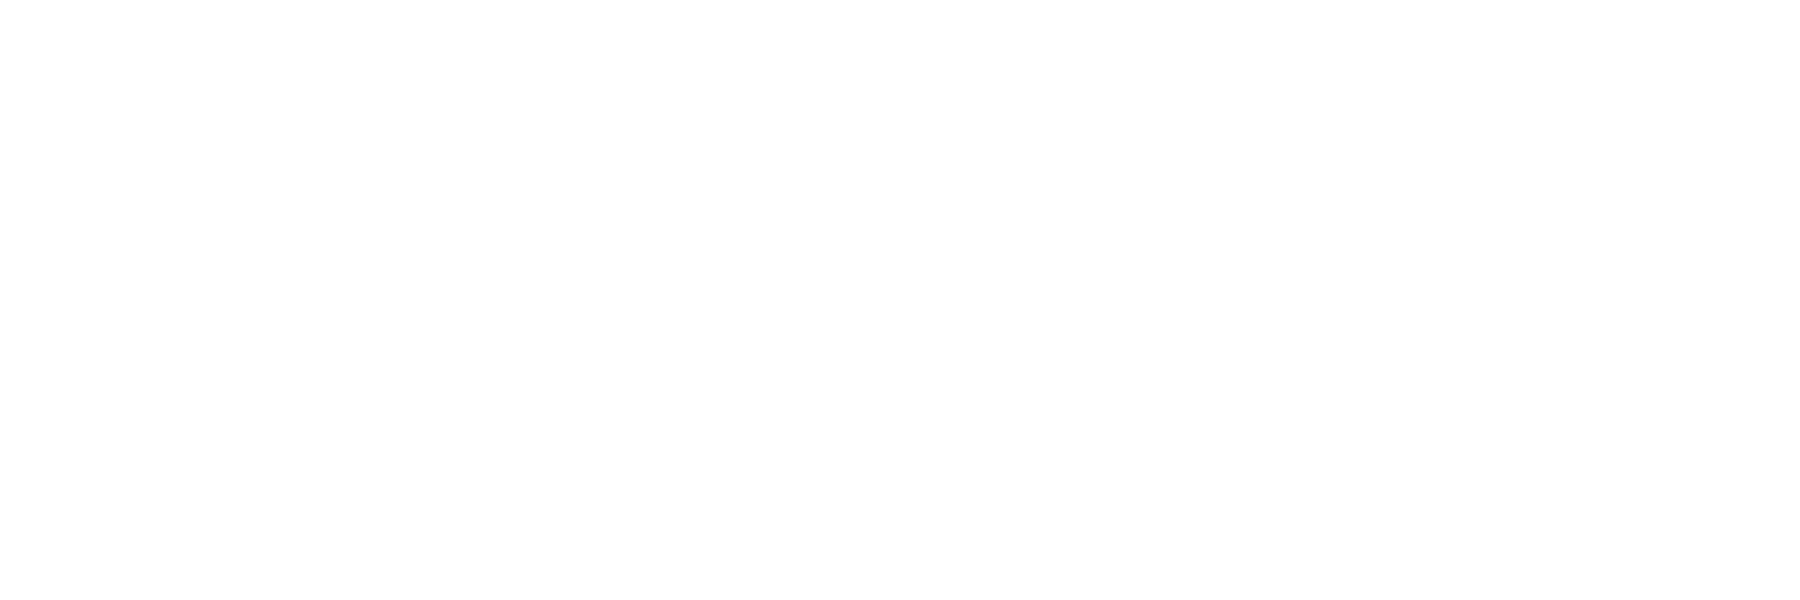

In [2]:
# Compare RFLO learning, RTRL, and BPTT for producing a simple periodic output.

n_in, n_rec, n_out = 1, 50, 1  # number of inputs, recurrent units, and outputs
duration = 100  # number of timesteps in one period

# Input to RNN
x_tonic = 0.0*np.ones((duration, n_in))

# Target RNN output:
y_target = np.outer(np.sin(2*np.pi*np.arange(duration)/duration)
                    + 0.5*np.sin(2*2*np.pi*np.arange(duration)/duration)
                    + 0.25*np.sin(4*2*np.pi*np.arange(duration)/duration), np.ones(n_out))

n_tr = 10000  # number of trials to train on 

h_init = 0.1*np.ones(n_rec)  # initial state of the RNN
    
print('\nTraining with BPTT...')
net1 = RNN(n_in, n_rec, n_out, h_init)
learn_rates = [0.0, 0.03, 0.03]
_, loss_list1, _ = net1.run_session(n_tr, x_tonic, y_target, eta=learn_rates,
                                       learning='bptt', online_learning=False)

print('\nTraining with RFLO...')
net2 = RNN(n_in, n_rec, n_out, h_init)
learn_rates = [0.0, 0.03, 0.03]
_, loss_list2, _ = net2.run_session(n_tr, x_tonic, y_target, eta=learn_rates,
                                       learning='rflo', online_learning=False)

# Skip training with RTRL because it's very slow.
#print('\nTraining with RTRL...')
#net3 = RNN(n_in, n_rec, n_out, h_init)
#learn_rates = [0.0, 0.03, 0.03]
#_, loss_list3, _ = net3.run_session(n_tr, x_tonic, y_target, eta=learn_rates,
#                                       learning='rtrl', online_learning=False)


<IPython.core.display.Javascript object>


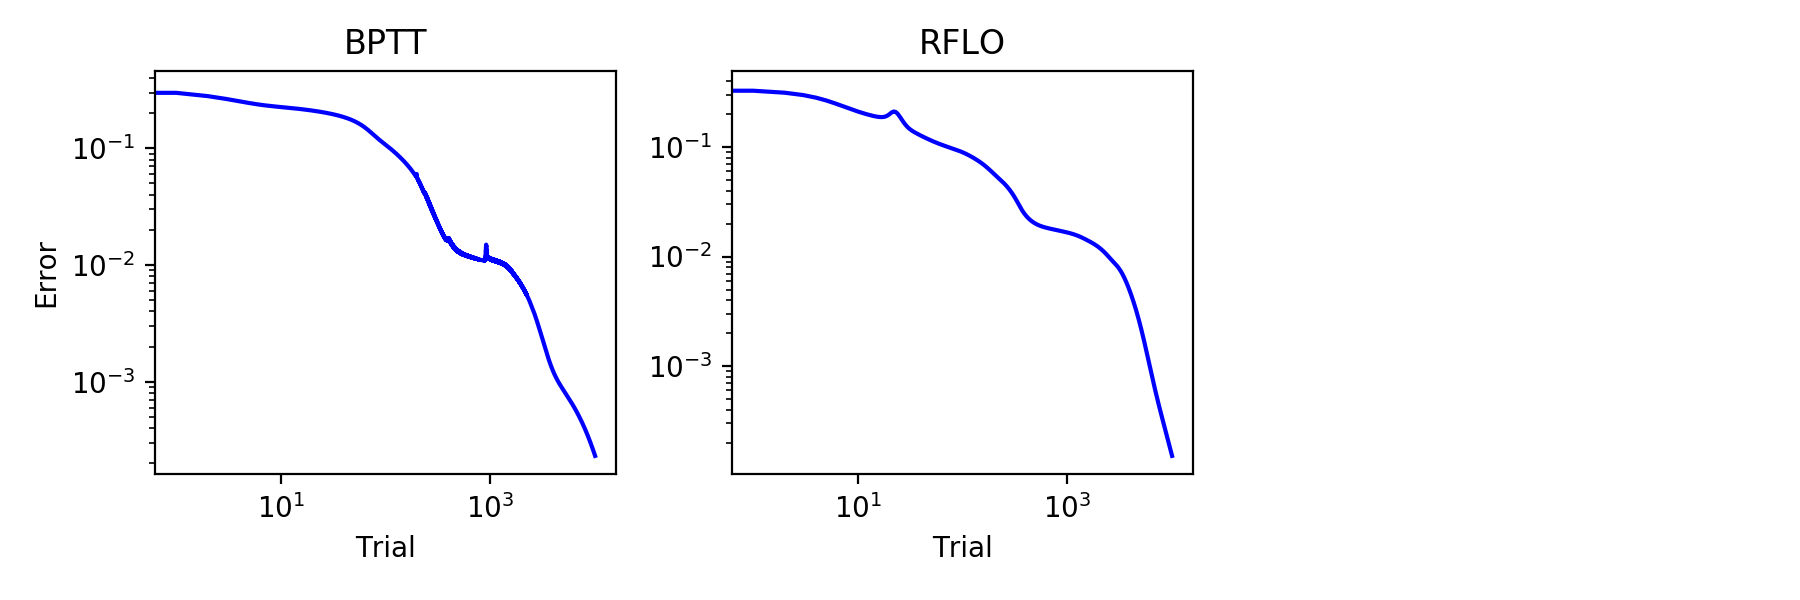

In [6]:
# Plot the results.

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.loglog(loss_list1, 'b')
plt.title('BPTT')
plt.ylabel('Error')
plt.xlabel('Trial')

plt.subplot(132)
plt.loglog(loss_list2, 'b')
plt.title('RFLO')
plt.xlabel('Trial')

#plt.subplot(133)
#plt.loglog(loss_list3, 'b')
#plt.title('RTRL')
#plt.xlabel('Trial')

plt.tight_layout()


<IPython.core.display.Javascript object>


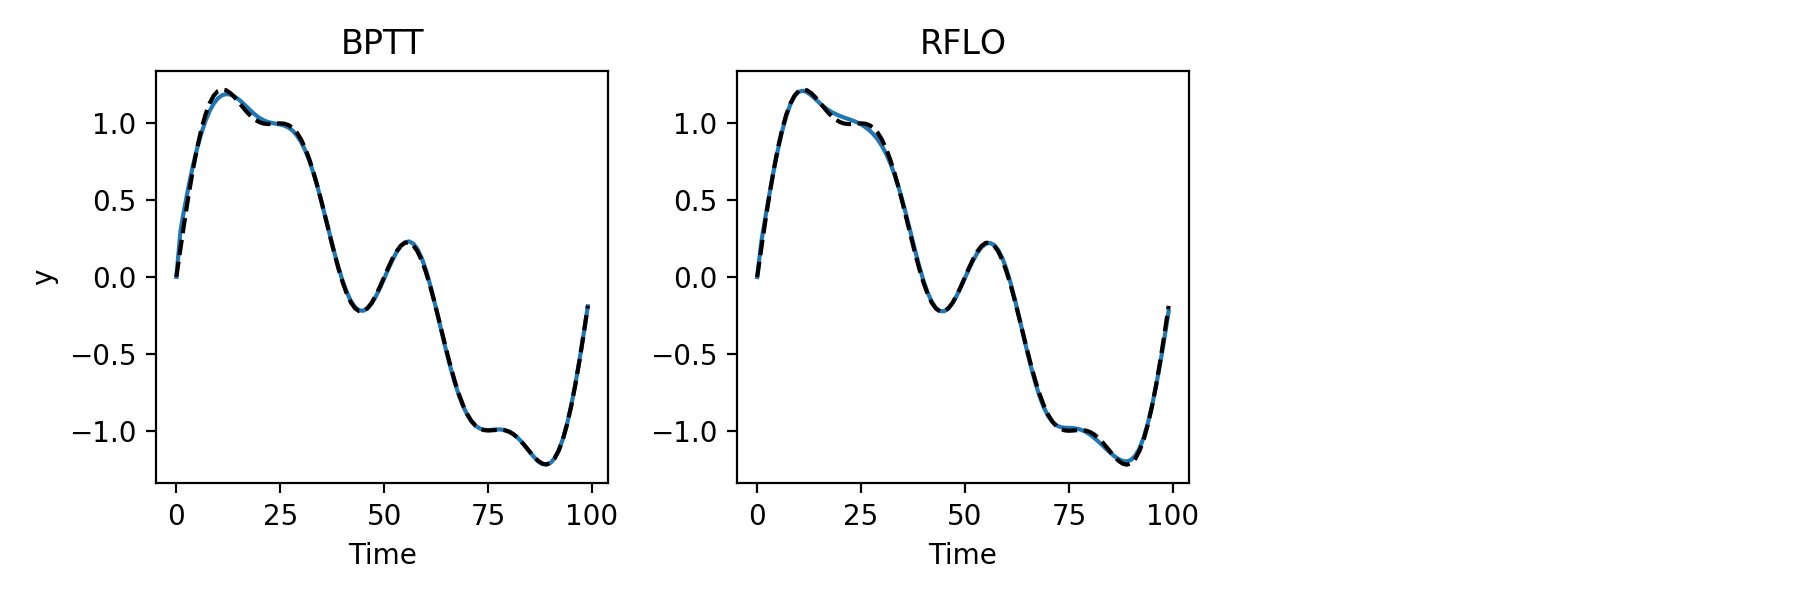

In [7]:
# Test the networks with learning turned off:
y1, _, _ = net1.run_trial(x_tonic, y_target, learning=False)
y2, _, _ = net2.run_trial(x_tonic, y_target, learning=False)
#y3, _, _ = net3.run_trial(x_tonic, y_target, learning=False)


# Plot the RNN output along with the target output:
plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.plot(y1)
plt.plot(y_target, '--k')
plt.title('BPTT')
plt.ylabel('y')
plt.xlabel('Time')

plt.subplot(132)
plt.plot(y2)
plt.plot(y_target, '--k')
plt.title('RFLO')
plt.xlabel('Time')

#plt.subplot(133)
#plt.plot(y3)
#plt.plot(y_target, '--k')
#plt.title('RTRL')
#plt.xlabel('Time')

plt.tight_layout()
